In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

In [3]:
batch_size = 32
img_height = 150
img_width = 150

In [4]:
data_dir='ct-ori-dataset'
train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [5]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [6]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


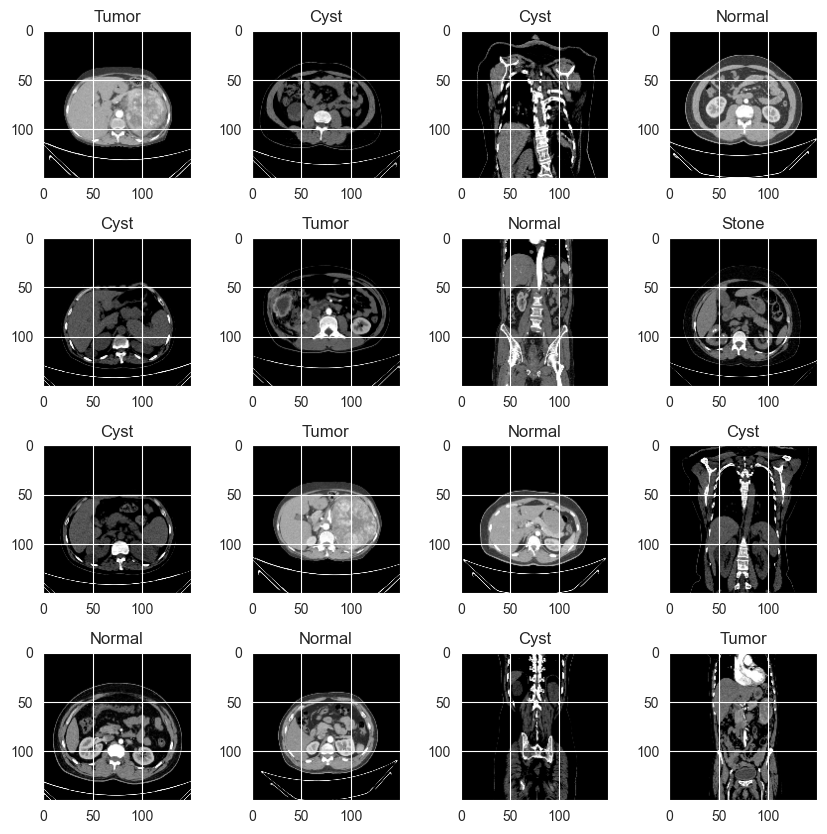

In [7]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [8]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Mobile-Net Training

In [10]:
mobile_net = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(150,150,3),
                   pooling='max',classes=4,
                   weights='imagenet')


mobile_net.add(pretrained_model)
mobile_net.add(Flatten())
mobile_net.add(Dense(512, activation='relu'))
mobile_net.add(BatchNormalization())  # Batch Normalization layer
mobile_net.add(Dropout(0.5))

mobile_net.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

9406464/9406464 [==============================] - 39s 4us/step


In [11]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [12]:
mobile_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [ ]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
img = cv2.imread('test.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

In [ ]:
mobile_net.save("model.h5")

# Load Model

In [ ]:
loaded_model = tf.keras.models.load_model("model.h5")

In [ ]:
img = cv2.imread('test.jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (150,150))
yhat = loaded_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]